<a href="https://colab.research.google.com/github/mehmetkesik/tensorflow-basics/blob/main/04_transfer_learning_in_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leverage a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture while has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
# Imports
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import sklearn

In [ ]:
# Are we using a GPU?
!nvidia-smi

Sun Nov 27 18:39:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
tf.get_logger().setLevel('ERROR')

## Downloading and becoming one with data

In [ ]:
# Get data (10% oof 10 food classes from Food101)
import zipfile
from pathlib import Path

# Download the data
if not Path("10_food_classes_10_percent").is_dir():
  !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

  # Unzip the downloaded file
  zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
  zip_ref.extractall()
  zip_ref.close()

--2022-11-27 18:39:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  24.0MB/s    in 7.8s    

2022-11-27 18:39:33 (20.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_ric

## Creating data loaders (preparing the data)

We'll use the `image_dataset_from_folder` function to load in our images in batches.

In [ ]:
# Setup data inputs
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

rescaling = layers.Rescaling(1./255)

print("Training images:")
train_data = image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)#.map(lambda x, y: (rescaling(x), y))
class_names = train_data.class_names
num_classes = len(class_names)
train_data = train_data.map(lambda x, y: (rescaling(x), y))

print("Test images:")
test_data = image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
).map(lambda x, y: (rescaling(x), y))

Training images:
Found 750 files belonging to 10 classes.
Test images:
Found 2500 files belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callback are extra functionality you can add to your models to be performed during or after training. Some of the popular callbacks:

* Traking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback


In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log file to: {log_dir}")
  return tensorboard_callback

🔑 **Note:** You can customize the directory where you TensorBoard logs(model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from stratch.

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev

https://paperswithcode.com/sota

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Let's make a create_model() function to create a model frol a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
      layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                      trainable=False,
                                      name="feature_extractor_layer",
                                      input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned patterns
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  
  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2")])

Saving TensorBoard log file to: tensorflow_hub/resnet50v2/20221127-183947
Epoch 1/5
24/24 [==============================] - 25s 577ms/step - loss: 1.9049 - accuracy: 0.3707 - val_loss: 1.1500 - val_accuracy: 0.6428
Epoch 2/5
24/24 [==============================] - 9s 379ms/step - loss: 0.8797 - accuracy: 0.7387 - val_loss: 0.8336 - val_accuracy: 0.7428
Epoch 3/5
24/24 [==============================] - 13s 528ms/step - loss: 0.6145 - accuracy: 0.8253 - val_loss: 0.7285 - val_accuracy: 0.7588
Epoch 4/5
24/24 [==============================] - 9s 381ms/step - loss: 0.4676 - accuracy: 0.8787 - val_loss: 0.6869 - val_accuracy: 0.7688
Epoch 5/5
24/24 [==============================] - 13s 530ms/step - loss: 0.3767 - accuracy: 0.9027 - val_loss: 0.6565 - val_accuracy: 0.7736


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time and with only 10% of the training examples.

In [ ]:
# Download helper functions
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exist, skipping download...")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mehmetkesik/tensorflow-basics/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

# Import helper functions
from helper_functions import *

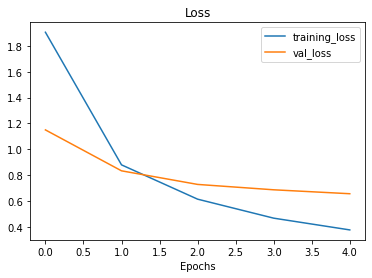

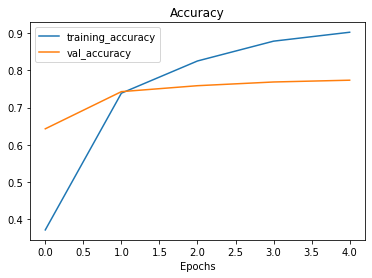

In [ ]:
# Plot the validation and training curves
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficientNetB0 feature extractor model - details on EfficientNet: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficientnet_model = create_model(efficientnet_url,
                                  num_classes=num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=Adam(),
                           metrics=["accuracy"])

In [ ]:
# Fit EfficientNet model 10% of training data
efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20221127-184110
Epoch 1/5
24/24 [==============================] - 19s 391ms/step - loss: 1.8644 - accuracy: 0.4160 - val_loss: 1.2957 - val_accuracy: 0.7248
Epoch 2/5
24/24 [==============================] - 8s 330ms/step - loss: 1.0591 - accuracy: 0.7733 - val_loss: 0.8560 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 8s 325ms/step - loss: 0.7517 - accuracy: 0.8293 - val_loss: 0.6857 - val_accuracy: 0.8520
Epoch 4/5
24/24 [==============================] - 12s 514ms/step - loss: 0.6022 - accuracy: 0.8733 - val_loss: 0.5992 - val_accuracy: 0.8620
Epoch 5/5
24/24 [==============================] - 8s 334ms/step - loss: 0.5084 - accuracy: 0.8987 - val_loss: 0.5457 - val_accuracy: 0.8684


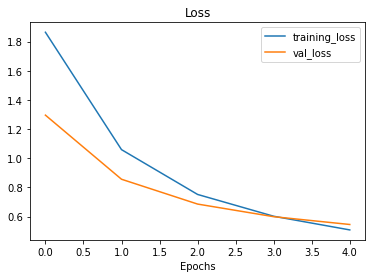

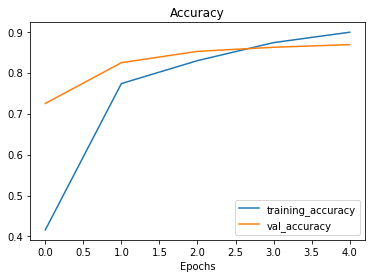

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
effnetb7_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"

effnetb7_model = create_model(effnetb7_url,
                              num_classes=num_classes)

effnetb7_model.compile(loss="categorical_crossentropy",
                       optimizer=Adam(),
                       metrics=["accuracy"])

effnetb7_history = effnetb7_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="effnetb7")])

Saving TensorBoard log files to: tensorflow_hub/effnetb7/20221127-184303
Epoch 1/5
24/24 [==============================] - 72s 2s/step - loss: 1.6554 - accuracy: 0.5200 - val_loss: 0.9836 - val_accuracy: 0.8008
Epoch 2/5
24/24 [==============================] - 50s 2s/step - loss: 0.8027 - accuracy: 0.8187 - val_loss: 0.6716 - val_accuracy: 0.8372
Epoch 3/5
24/24 [==============================] - 39s 2s/step - loss: 0.5912 - accuracy: 0.8613 - val_loss: 0.5738 - val_accuracy: 0.8488
Epoch 4/5
24/24 [==============================] - 37s 2s/step - loss: 0.4859 - accuracy: 0.8800 - val_loss: 0.5278 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 50s 2s/step - loss: 0.4127 - accuracy: 0.9080 - val_loss: 0.4944 - val_accuracy: 0.8644


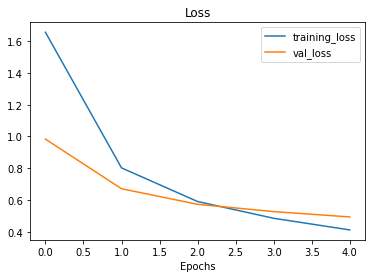

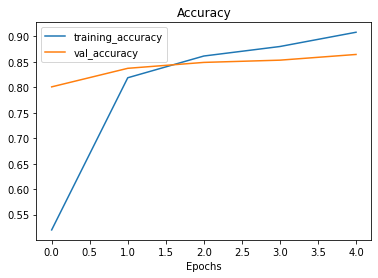

In [ ]:
plot_loss_curves(effnetb7_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of training data" \
  --one_shot

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/bFBQc2KjRF6x3W1vvivulA/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/bFBQc2KjRF6x3W1vvivulA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of training data
	Id                   bFBQc2KjRF6x3W1vvivulA
	Created              2022-11-27 19:17:01 (5 minutes ago)
	Updated              2022-11-27 19:17:06 (5 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  5792298
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id bFBQc2KjRF6x3W1vvivulA

Deleted experiment bFBQc2KjRF6x3W1vvivulA.


In [ ]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.


Check out: https://wandb.ai/